In [183]:
from abc import ABC, abstractmethod
import os
import pickle
import collections
import numpy as np
import random


class Learner:
    """
    Parent class for Q-learning and SARSA agents.

    Parameters
    ----------
    alpha : float
        learning rate
    gamma : float
        temporal discounting rate
    eps : float
        probability of random action vs. greedy action
    eps_decay : float
        epsilon decay rate. Larger value = more decay
    """
    def __init__(self, alpha, gamma, eps, eps_decay=0., size=3):
        # Agent parameters
        self.size = size
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        # Possible actions correspond to the set of all x,y coordinate pairs
        self.actions = []
        for i in range(size):
            for j in range(size):
                self.actions.append((i,j))
        # Initialize Q values to 0 for all state-action pairs.
        # Access value for action a, state s via Q[a][s]
        self.Q = {}
        for action in self.actions:
            self.Q[action] = collections.defaultdict(int)
        # Keep a list of reward received at each episode
        self.rewards = []

    def get_action(self, s):
        """
        Select an action given the current game state.

        Parameters
        ----------
        s : string
            state
        """
        # Only consider the allowed actions (empty board spaces)
        possible_actions = [a for a in self.actions if s[a[0]*self.size + a[1]] == '-']
        if random.random() < self.eps:
            # Random choose.
            action = possible_actions[random.randint(0,len(possible_actions)-1)]
        else:
            # Greedy choose.
            values = np.array([self.Q[a][s] for a in possible_actions])
            # Find location of max
            ix_max = np.where(values == np.max(values))[0]
            if len(ix_max) > 1:
                # If multiple actions were max, then sample from them
                ix_select = np.random.choice(ix_max, 1)[0]
            else:
                # If unique max action, select that one
                ix_select = ix_max[0]
            action = possible_actions[ix_select]

        # update epsilon; geometric decay
        self.eps *= (1.-self.eps_decay)

        return action

    def save(self, path):
        """ Pickle the agent object instance to save the agent's state. """
        if os.path.isfile(path):
            os.remove(path)
        f = open(path, 'wb')
        pickle.dump(self, f)
        f.close()


    def update(self, s, s_, a, a_, r):
        pass

    def update_by_episode(self, episode):
        pass


class MonteCarlo(Learner):

    def __init__(self, alpha, gamma, eps, eps_decay=0., size=3):
        super().__init__(alpha, gamma, eps, eps_decay, size)
        self.N = collections.defaultdict(int)

    def update(self, s, s_, a, a_, r):
        self.N[s] += 1
        self.Q[a][s] += 1 / self.N[s] * (r + self.gamma * self.Q[a_][s_] - self.Q[a][s])

    def update_by_episode(self, episode):
        episode = episode[::-1]

        for i in range(len(episode) - 1):
            s, a, s_, r = episode[i]
            a_ = episode[i + 1][1]
            self.update(s, s_, a, a_, r)
        self.rewards.append(episode[0][3])

class Qlearner(Learner):
    """
    A class to implement the Q-learning agent.
    """
    def __init__(self, alpha, gamma, eps, eps_decay=0., size=3):
        super().__init__(alpha, gamma, eps, eps_decay, size)

    def update(self, s, s_, a, r):
        """
        Perform the Q-Learning update of Q values.

        Parameters
        ----------
        s : string
            previous state
        s_ : string
            new state
        a : (i,j) tuple
            previous action
        a_ : (i,j) tuple
            new action. NOT used by Q-learner!
        r : int
            reward received after executing action "a" in state "s"
        """
        # Update Q(s,a)
        if s_ is not None:
            # hold list of Q values for all a_,s_ pairs. We will access the max later
            possible_actions = [action for action in self.actions if s_[action[0]*self.size + action[1]] == '-']
            # print(s_)
            Q_options = [self.Q[action][s_] for action in possible_actions]
            # update
            self.Q[a][s] += self.alpha*(r + self.gamma*max(Q_options) - self.Q[a][s])
        else:
            # terminal state update
            self.Q[a][s] += self.alpha*(r - self.Q[a][s])

        # add r to rewards list
        self.rewards.append(r)


class SARSAlearner(Learner):
    """
    A class to implement the SARSA agent.
    """
    def __init__(self, alpha, gamma, eps, eps_decay=0., size=3):
        super().__init__(alpha, gamma, eps, eps_decay, size)

    def update(self, s, s_, a, a_, r):
        """
        Perform the SARSA update of Q values.

        Parameters
        ----------
        s : string
            previous state
        s_ : string
            new state
        a : (i,j) tuple
            previous action
        a_ : (i,j) tuple
            new action
        r : int
            reward received after executing action "a" in state "s"
        """
        # Update Q(s,a)
        if s_ is not None:
            self.Q[a][s] += self.alpha*(r + self.gamma*self.Q[a_][s_] - self.Q[a][s])
        else:
            # terminal state update
            self.Q[a][s] += self.alpha*(r - self.Q[a][s])

        # add r to rewards list
        self.rewards.append(r)

def printBoard(board, size):
    """
    Prints the game board as text output to the terminal.

    Parameters
    ----------
    board : list of lists
        the current game board
    size : int
        the size of the board (3, 4, or 5)
    """
    header = '    ' + '   '.join(str(i) for i in range(size))
    print(header + '\n')
    for i, row in enumerate(board):
        print('%i   ' % i, end='')
        for elt in row:
            print('%s   ' % elt, end='')
        print('\n')


def getStateKey(board):
    """
    Converts 2D list representing the board state into a string key
    for that state. Keys are used for Q-value hashing.

    Parameters
    ----------
    board : list of lists
        the current game board
    """
    return ''.join(''.join(row) for row in board)

class QlearnerFA(Learner):
    """
    A Q-learning agent with linear function approximation.
    """
    def __init__(self, alpha, gamma, eps, eps_decay=0., size=3):
        super().__init__(alpha, gamma, eps, eps_decay, size)
        self.num_features = size * size * 2
        self.weights = np.random.uniform(-0.1, 0.1, self.num_features)
        self.rewards = []

    def get_features(self, s, a):

        features = np.zeros(self.num_features)
        for i in range(self.size):
            for j in range(self.size):
                if s[i*self.size + j] == 'O':
                    features[i*self.size + j] = 1
                elif s[i*self.size + j] == 'X':
                    features[self.size*self.size + i*self.size + j] = -1

        # Encode the action as a feature
        features[self.size * self.size + a[0] * self.size + a[1]] = 1

        return features

    def get_Q(self, s, a):

        if a is None:
            return 0
        features = self.get_features(s, a)
        return np.dot(self.weights, features)

    def get_action(self, s):

        possible_actions = [a for a in self.actions if s[a[0] * self.size + a[1]] == '-']


        if not possible_actions:
            return None

        if random.random() < self.eps:
            action = random.choice(possible_actions)
        else:

            values = np.array([self.get_Q(s, a) for a in possible_actions])
            ix_max = np.where(values == np.max(values))[0]
            action = possible_actions[random.choice(ix_max)]


        self.eps *= (1. - self.eps_decay)
        return action

    def update(self, s, s_, a, r):

        features = self.get_features(s, a)


        if s_ is not None:
            possible_actions = [a for a in self.actions if s_[a[0] * self.size + a[1]] == '-']
            if possible_actions:
                Q_s_ = max([self.get_Q(s_, a_) for a_ in possible_actions])
            else:
                Q_s_ = 0
        else:
            Q_s_ = 0

        Q_sa = self.get_Q(s, a)
        td_error = r + self.gamma * Q_s_ - Q_sa


        if not np.isnan(td_error) and not np.isinf(td_error):
            self.weights += np.clip(self.alpha * td_error * features, -10, 10)


        self.rewards.append(r)



In [184]:
import os
import pickle
import sys
import numpy as np
import matplotlib.pylab as plt

def plot_agent_reward(rewards, size, name):
    """ Function to plot agent's accumulated reward vs. iteration """

    # Plot cumulative rewards
    plt.plot(np.cumsum(rewards))

    # Set the title and labels
    plt.title(f'Agent Cumulative Reward vs. Iteration {name} {size}x{size}')
    plt.ylabel('Reward')
    plt.xlabel('Episode')

    # Improve x-axis by adding more ticks
    num_episodes = len(rewards)
    plt.xticks(np.arange(0, num_episodes, step=max(1, num_episodes // 10)))  # Adjust the step to control tick frequency

    # Optionally, rotate x-tick labels if they overlap
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()


In [185]:
class Game:
    def __init__(self, agent_1, agent_2, size=3):
        self.agent_1 = agent_1
        self.agent_2 = agent_2
        self.size = size
        self.board = [['-' for _ in range(size)] for _ in range(size)]
        self.agent_1_wins = 0
        self.agent_2_wins = 0
        self.draws = 0

    def reset_board(self):
        self.board = [['-' for _ in range(self.size)] for _ in range(self.size)]

    def agent1Move(self, action):
        self.board[action[0]][action[1]] = 'O'

    def agent2Move(self, action):
        self.board[action[0]][action[1]] = 'X'

    def checkForWin(self, key):
        diag1 = [self.board[i][i] for i in range(self.size)]
        diag2 = [self.board[i][self.size - i - 1] for i in range(self.size)]
        if diag1.count(key) == self.size or diag2.count(key) == self.size:
            return True

        for i in range(self.size):
            row = [self.board[i][j] for j in range(self.size)]
            col = [self.board[j][i] for j in range(self.size)]
            if row.count(key) == self.size or col.count(key) == self.size:
                return True

        return False

    def checkForDraw(self):
        return all(elt != '-' for row in self.board for elt in row)

    def checkForEnd(self, key):
        if self.checkForWin(key):
            return 1
        elif self.checkForDraw():
            return 0
        return -1

    def playGame(self):
        agent1_prev_state = getStateKey(self.board)
        agent1_action = self.agent_1.get_action(agent1_prev_state)
        if agent1_action is None:
            return

        self.agent1Move(agent1_action)

        while True:
            agent2_prev_state = getStateKey(self.board)
            possible_actions = [a for a in self.agent_2.actions if self.board[a[0]][a[1]] == '-']

            if not possible_actions:
                break

            agent2_action = random.choice(possible_actions)
            self.agent2Move(agent2_action)

            if self.checkForEnd('X') != -1:
                reward = self.checkForEnd('X')
                self.agent_1.update(agent1_prev_state, None, agent1_action, -reward)
                if reward == 1:
                    self.agent_2_wins += 1
                else:
                    self.draws += 1
                break
            self.agent_1.update(agent1_prev_state, getStateKey(self.board), agent1_action, 0)

            agent1_prev_state = getStateKey(self.board)
            agent1_action = self.agent_1.get_action(agent1_prev_state)

            if agent1_action is None:
                break

            self.agent1Move(agent1_action)
            if self.checkForEnd('O') != -1:
                reward = self.checkForEnd('O')
                self.agent_1.update(agent1_prev_state, None, agent1_action, reward)
                if reward == 1:
                    self.agent_1_wins += 1
                else:
                    self.draws += 1
                break

        self.reset_board()

    def start(self, episodes=1000):
        for episode in range(episodes):
            self.playGame()
            if episode % 1000 == 0:
              total_games = self.agent_1_wins + self.agent_2_wins + self.draws
              print(f"Q-learning Agent Wins: {self.agent_1_wins} ({(self.agent_1_wins / total_games) * 100:.2f}%)")
              print(f"Random Agent Wins: {self.agent_2_wins} ({(self.agent_2_wins / total_games) * 100:.2f}%)")
              print(f"Draws: {self.draws} ({(self.draws / total_games) * 100:.2f}%)")
              self.agent_1_wins, self.agent_2_wins, self.draws = 0, 0, 0




# Deep-Q-Learning Implementation

In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from typing import List

In [178]:

class MLP(nn.Module):
  def __init__(self, input_dim: int = 9, hidden_dim: List[int] = [64, 32], output_dim: int=9):
    super(MLP, self).__init__()
    self.fc0 = nn.Linear(input_dim, hidden_dim[0])
    self.hidden_layer = [
      nn.Linear(hidden_dim[_ - 1], hidden_dim[_]) for _ in range(1, len(hidden_dim))
    ]
    self.fc_output = nn.Linear(hidden_dim[-1], output_dim)

  def forward(self, state):
    x = F.relu(self.fc0(torch.reshape(state, (-1,))))
    for layer in self.hidden_layer:
      x = F.relu(layer(x))
    x = F.relu(self.fc_output(x))
    return x



In [179]:
import torch
import torch.nn as nn
import torch.optim as optim
import random


class DeepQLearner:
    """
    A Deep Q-Learning agent for Tic-Tac-Toe or similar environments.
    """

    def __init__(self, model, alpha=0.01, gamma=0.99, eps=1.0, eps_decay=0.01, size=3):
        """
        Initialize the Deep Q-Learning agent.

        Args:
            model (torch.nn.Module): Neural network for Q-value approximation.
            actions (list): List of all possible actions.
            alpha (float): Learning rate for the optimizer.
            gamma (float): Discount factor for future rewards.
            eps (float): Initial exploration rate for epsilon-greedy policy.
            eps_decay (float): Rate of decay for epsilon.
            size (int): Size of the board (e.g., 3 for 3x3 Tic-Tac-Toe).
        """
        self.model = model
        self.actions = []
        for i in range(size):
            for j in range(size):
                self.actions.append((i,j))
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.size = size
        self.num_features = size * size
        self.rewards = []


        self.optim = optim.Adam(self.model.parameters(), lr=alpha)
        self.critic = nn.MSELoss()

    def get_features(self, s):
        """
        Convert the board state into feature representation.
        Args:
            s (list): The board state as a flat list.

        Returns:
            torch.Tensor: Feature vector representing the state.
        """
        if s is None:
            return None
        features = torch.tensor([1 if cell == 'O' else -1 if cell == 'X' else 0 for cell in s], dtype=torch.float32)
        return features

    def get_Q(self, s, a):
        """
        Get the Q-value for a specific state-action pair.
        Args:
            s (list): Current state.
            a (tuple): Action to evaluate.

        Returns:
            float: Q-value for the state-action pair.
        """
        if a is None:
            raise ValueError("Action cannot be None")
        q_values = self.model(self.get_features(s).unsqueeze(0))
        return q_values[a[0] * self.size + a[1]].item()

    def get_action(self, s):
        """
        Choose an action using epsilon-greedy policy.
        Args:
            s (list): Current state.

        Returns:
            tuple: Selected action.
        """
        possible_actions = [a for a in self.actions if s[a[0] * self.size + a[1]] == '-']

        if not possible_actions:
            return None

        if random.random() < self.eps:

            action = random.choice(possible_actions)
        else:

            q_values = torch.tensor([self.get_Q(s, a) for a in possible_actions], dtype=torch.float32)
            max_index = torch.argmax(q_values).item()
            action = possible_actions[max_index]


        self.eps = max(0.01, self.eps * (1 - self.eps_decay))
        return action

    def update(self, s, s_, a, r):
        """
        Update the Q-network based on the given transition (s, a, r, s_).
        Args:
            s (list): Current state.
            s_ (list): Next state (None if terminal).
            a (tuple): Action taken in the current state.
            r (float): Reward received for taking the action.
        """
        state_tensor = torch.tensor(self.get_features(s), dtype=torch.float32).unsqueeze(0)
        next_state_tensor = None if s_ is None else torch.tensor(self.get_features(s_), dtype=torch.float32).unsqueeze(0)

        q_values = self.model(state_tensor)
        action_index = a[0] * self.size + a[1]
        q_sa = q_values[action_index]

        if s_ is not None:
            next_q_values = self.model(next_state_tensor).detach()
            max_next_q = torch.max(next_q_values).item()
            q_target = r + self.gamma * max_next_q
        else:
            q_target = r


        q_target_tensor = torch.tensor([q_target], dtype=torch.float32)
        loss = self.critic(q_target_tensor, q_sa.unsqueeze(0))


        self.optim.zero_grad()
        loss.backward()
        self.optim.step()


        self.rewards.append(r)

    def save_model(self, path):
        """
        Save the model's parameters to the specified path.
        Args:
            path (str): Path to save the model.
        """
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        """
        Load the model's parameters from the specified path.
        Args:
            path (str): Path to load the model from.
        """
        self.model.load_state_dict(torch.load(path))
        self.model.eval()

In [197]:
model = MLP()

In [198]:
deep_q_learning = DeepQLearner(alpha=0.5, gamma=0.9, eps=0.5, size=3, model=model)
random_agent = Learner(alpha=0, gamma=0, eps=0, size=3)
game = Game(agent_1=deep_q_learning, agent_2=random_agent, size=3)

In [199]:
game.start(100000)

<ipython-input-179-337515788896>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(self.get_features(s), dtype=torch.float32).unsqueeze(0)
<ipython-input-179-337515788896>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state_tensor = None if s_ is None else torch.tensor(self.get_features(s_), dtype=torch.float32).unsqueeze(0)


Q-learning Agent Wins: 1 (100.00%)
Random Agent Wins: 0 (0.00%)
Draws: 0 (0.00%)
Q-learning Agent Wins: 489 (48.90%)
Random Agent Wins: 273 (27.30%)
Draws: 238 (23.80%)
Q-learning Agent Wins: 465 (46.50%)
Random Agent Wins: 288 (28.80%)
Draws: 247 (24.70%)
Q-learning Agent Wins: 472 (47.20%)
Random Agent Wins: 284 (28.40%)
Draws: 244 (24.40%)
Q-learning Agent Wins: 453 (45.30%)
Random Agent Wins: 307 (30.70%)
Draws: 240 (24.00%)
Q-learning Agent Wins: 463 (46.30%)
Random Agent Wins: 276 (27.60%)
Draws: 261 (26.10%)
Q-learning Agent Wins: 514 (51.40%)
Random Agent Wins: 252 (25.20%)
Draws: 234 (23.40%)
Q-learning Agent Wins: 485 (48.50%)
Random Agent Wins: 270 (27.00%)
Draws: 245 (24.50%)
Q-learning Agent Wins: 461 (46.10%)
Random Agent Wins: 278 (27.80%)
Draws: 261 (26.10%)
Q-learning Agent Wins: 474 (47.40%)
Random Agent Wins: 281 (28.10%)
Draws: 245 (24.50%)
Q-learning Agent Wins: 476 (47.60%)
Random Agent Wins: 302 (30.20%)
Draws: 222 (22.20%)
Q-learning Agent Wins: 492 (49.20%)
Ran

KeyboardInterrupt: 

# Function Approximate

In [10]:
q_learning_agent_fa = QlearnerFA(alpha=0.5, gamma=0.9, eps=0.1, size=3)
random_agent = Learner(alpha=0, gamma=0, eps=0, size=3)
game = Game(agent_1=q_learning_agent_fa, agent_2=random_agent, size=3)

Q-learning Agent Wins: 5864 (58.64%)
Random Agent Wins: 2866 (28.66%)
Draws: 1270 (12.70%)


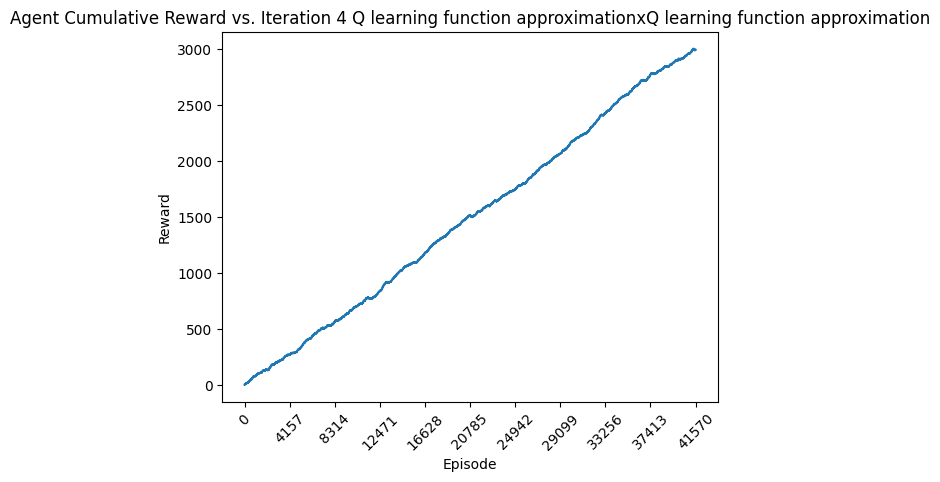

In [11]:
game.start(10000)


with open("q_learning_agent_fa.pkl", 'rb') as f:
    q_agent = pickle.load(f)

plot_agent_reward(q_agent.rewards, 'Q learning function approximation', 4)

# Q-Learning

In [190]:
q_learning = Qlearner(alpha=0.5, gamma=0.9, eps=0.1, size=5)
random_agent = Learner(alpha=0, gamma=0, eps=0, size=5)
game = Game(agent_1=q_learning, agent_2=random_agent, size=5)

In [191]:
game.start(10000)

Q-learning Agent Wins: 0 (0.00%)
Random Agent Wins: 0 (0.00%)
Draws: 1 (100.00%)
Q-learning Agent Wins: 258 (25.80%)
Random Agent Wins: 136 (13.60%)
Draws: 606 (60.60%)
Q-learning Agent Wins: 233 (23.30%)
Random Agent Wins: 166 (16.60%)
Draws: 601 (60.10%)
Q-learning Agent Wins: 206 (20.60%)
Random Agent Wins: 171 (17.10%)
Draws: 623 (62.30%)
Q-learning Agent Wins: 245 (24.50%)
Random Agent Wins: 134 (13.40%)
Draws: 621 (62.10%)
Q-learning Agent Wins: 239 (23.90%)
Random Agent Wins: 147 (14.70%)
Draws: 614 (61.40%)
Q-learning Agent Wins: 226 (22.60%)
Random Agent Wins: 170 (17.00%)
Draws: 604 (60.40%)
Q-learning Agent Wins: 269 (26.90%)
Random Agent Wins: 146 (14.60%)
Draws: 585 (58.50%)
Q-learning Agent Wins: 230 (23.00%)
Random Agent Wins: 165 (16.50%)
Draws: 605 (60.50%)
Q-learning Agent Wins: 253 (25.30%)
Random Agent Wins: 140 (14.00%)
Draws: 607 (60.70%)
